Transfer Learning 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, SpatialDropout2D
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data_dir = 'C:/Users/devea/Desktop/Machine Learning/image' 

In [22]:
# Initialize the data generators with a validation split
# Create a data generator for training
train_datagen = ImageDataGenerator(
   rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# Create a data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Specify the batch size
batch_size = 32

# Create the training dataset
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,  # Consider reducing batch size if dataset is small
    class_mode='categorical',
    subset='training')

val_ds =  train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,  # Consistent with training batch size
    class_mode='categorical',
    subset='validation')


Found 1957 images belonging to 5 classes.
Found 486 images belonging to 5 classes.


In [23]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  # 5 classes


In [24]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Set up the early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

In [35]:
# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // train_ds.batch_size,
    validation_data=val_ds,
    validation_steps=val_ds.samples // val_ds.batch_size,
    epochs=15,
    callbacks=[ early_stopping, reduce_lr]
)

Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step - accuracy: 0.8111 - loss: 0.5768 - val_accuracy: 0.8188 - val_loss: 0.5612 - learning_rate: 2.0000e-05
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4066 - val_accuracy: 0.8333 - val_loss: 0.1607 - learning_rate: 2.0000e-05
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 34s 534ms/step - accuracy: 0.7976 - loss: 0.5794 - val_accuracy: 0.8396 - val_loss: 0.5134 - learning_rate: 2.0000e-05
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.1951 - val_accuracy: 0.6667 - val_loss: 0.5234 - learning_rate: 2.0000e-05
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 548ms/step - accuracy: 0.8283 - loss: 0.5211 - val_accuracy: 0.8292 - val_loss: 0.5406 - learning_rate: 1.0000e-05


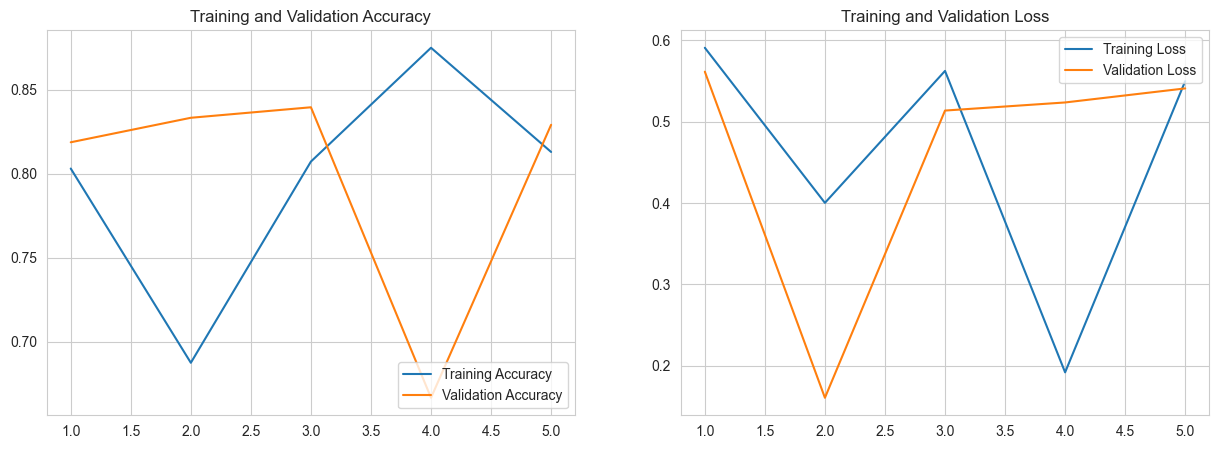

In [36]:
# Plot the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('T&V.png')
plt.show()

In [37]:
# Evaluate the model using the validation set
val_preds = model.predict(val_ds)
val_preds_classes = np.argmax(val_preds, axis=1)

true_classes = val_ds.classes
class_labels = list(val_ds.class_indices.keys())


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step


In [39]:
# Generate a classification report
print(classification_report(true_classes, val_preds_classes, target_names=class_labels))

SyntaxError: invalid syntax (3729927763.py, line 1)

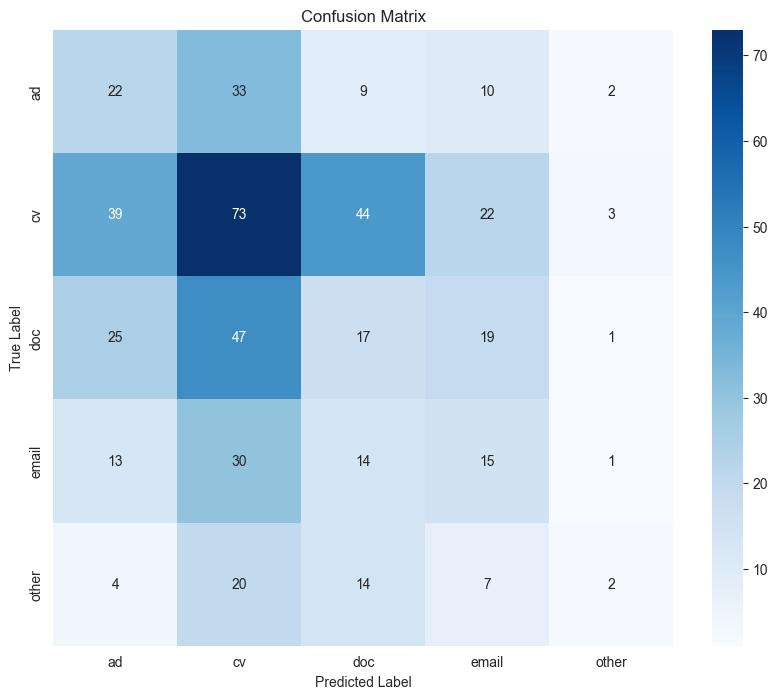

In [12]:
conf_matrix = confusion_matrix(true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('con.png')
plt.show()